In [1]:
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz

In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import cross_val_score
from IPython.display import Image, display_svg, SVG

/home/tristan/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tristan/miniconda3/lib/python3.8/site-packages/fastbook/__init__.py:11: UserWarning: Missing `ipywidgets` - please install it
  except ModuleNotFoundError: warn("Missing `ipywidgets` - please install it")
/home/tristan/miniconda3/lib/python3.8/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [3]:
path = Path.cwd()
Path.BASE_PATH = path
path.ls()

(#7) [Path('random_forest.ipynb'),Path('combined.db-shm'),Path('decision_tree.ipynb'),Path('preprocessed_train_valid.pkl'),Path('.ipynb_checkpoints'),Path('combined.db'),Path('combined.db-wal')]

In [4]:
to = load_pickle(path/'preprocessed_train_valid.pkl')

In [5]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [6]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
def accuracy(pred, y): return round(abs(y - pred).mean(), 2)
def m_accuracy(m, xs, y): return accuracy(m.predict(xs), y)

In [7]:
num_est = 80
def rf(xs, y, n_estimators=num_est,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [8]:
m = rf(xs, y)

In [10]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/home/tristan/miniconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/miniconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/miniconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/miniconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/miniconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/miniconda3/lib/python3.8/site-packages/sklearn/base.py:457: UserWa

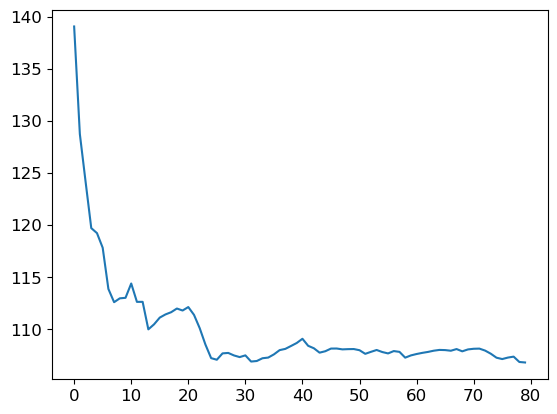

In [11]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(num_est)]);

In [12]:
r_mse(m.oob_prediction_, y)

128.249767

In [13]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [14]:
fi = rf_feat_importance(m, xs)

In [15]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [16]:
to_keep = fi[fi.imp>0.005].cols
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)
m_rmse(m, valid_xs_imp, valid_y), m_accuracy(m, valid_xs_imp, valid_y)

(107.795497, 61.8)

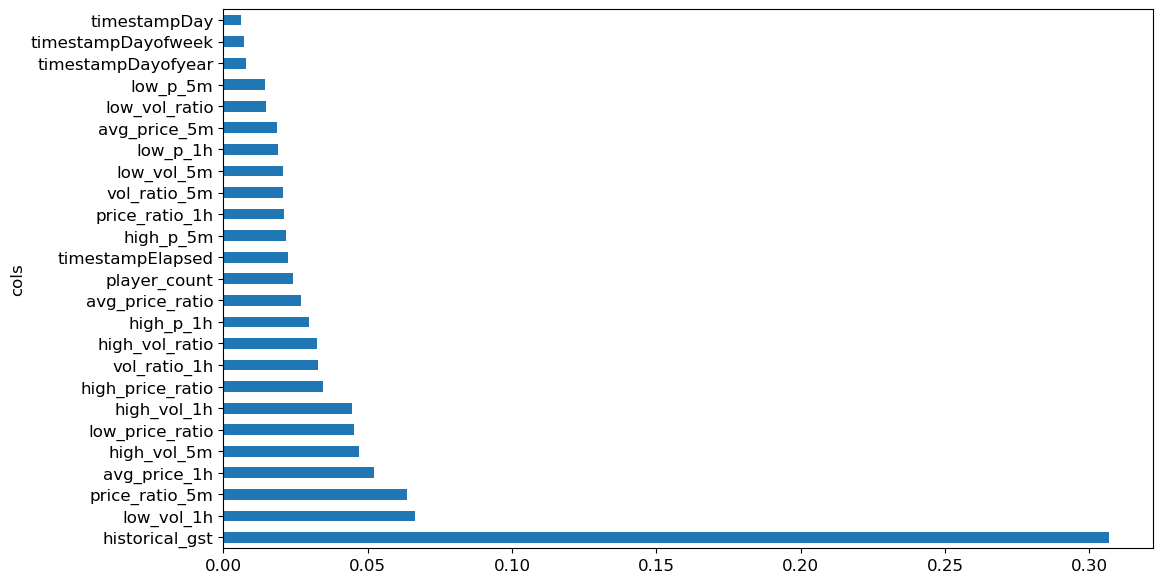

In [17]:
plot_fi(rf_feat_importance(m, xs_imp));

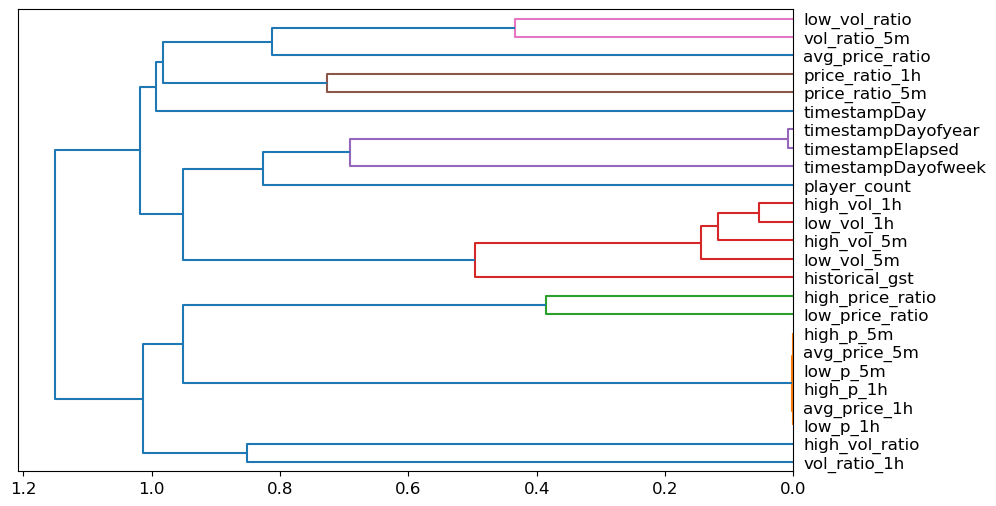

In [18]:
cluster_columns(xs_imp)

In [19]:
m.predict(valid_xs_imp.head())

array([57.07029191, 77.68640809, 29.06799991, 89.97522227, 10.37652082])

In [20]:
valid_y.head()

1892    225.731537
1895    135.338348
1897     35.236080
1899     26.595745
1900     15.225564
Name: gst, dtype: float32